In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [4]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:-1}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [5]:
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format = "%d-%m-%y",infer_datetime_format=True)
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format = "%d-%m-%y",infer_datetime_format=True)
now = pd.Timestamp('now')
df['Age'] = (now - df['Date.of.Birth']).astype('<m8[Y]').astype(int)
age_mean = int(df[df['Age']>0]['Age'].mean())
df.loc[:,'Age'] = df['Age'].apply(lambda x: x if x>0 else age_mean)
df['disbursal_months_passed'] = ((now - df['DisbursalDate'])/np.timedelta64(1,'M')).astype(int)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))

df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [6]:
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'],axis=1)

In [7]:
cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment',]

disbursed_amount


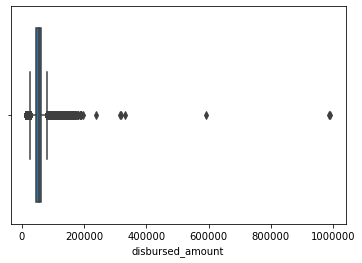

asset_cost


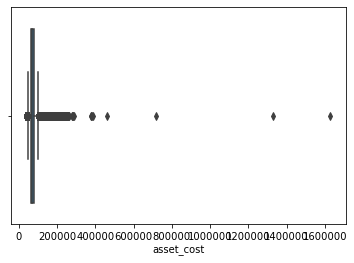

tot_current_balance


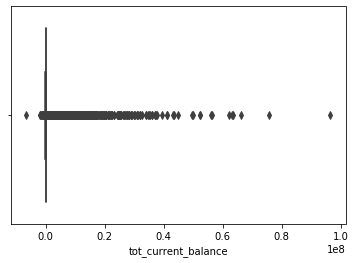

tot_sanctioned_amount


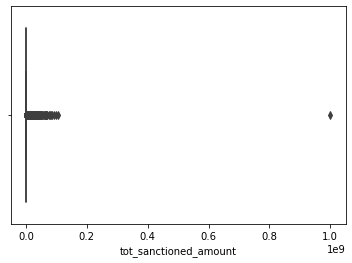

tot_disbursed_amount


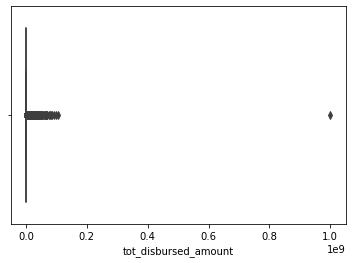

tot_installment


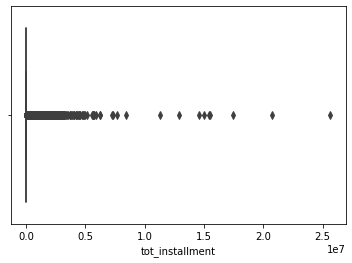

In [8]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [8]:
col,val=[],[]
for i in cols:
    q1=df[i].quantile(0.25)
    q3=df[i].quantile(0.75)
    iqr=q3-q1
    print(i, q3+iqr)
    df.loc[df[i] > q3+iqr,i] = np.nan

asset_cost 92686.5
tot_current_balance 74672.0
tot_sanctioned_amount 131299.5
tot_disbursed_amount 128568.0
tot_installment 4166.0


In [9]:
df.loc[df['tot_current_balance'] < q1-iqr,'tot_current_balance'] = np.nan

## Do the below graph after outlier treatment (above)

asset_cost


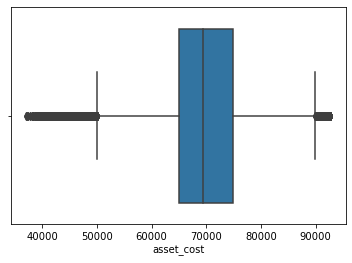

tot_current_balance


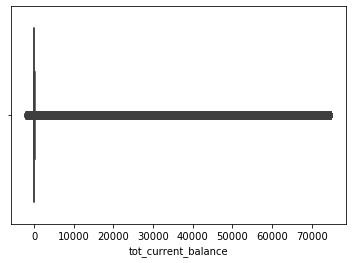

tot_sanctioned_amount


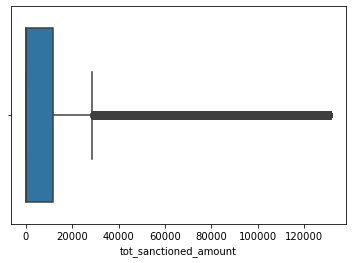

tot_disbursed_amount


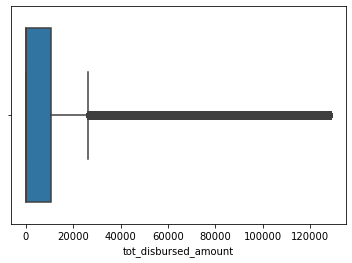

tot_installment


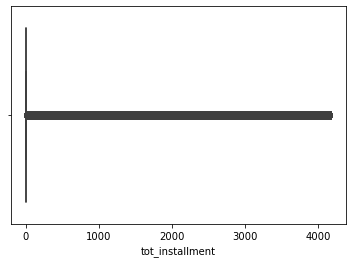

In [14]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [10]:
df.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'manufacturer_id',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'SEC.ACTIVE.ACCTS',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'Age', 'disbursal_months_passed', 'no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'tot_current_balance',
       'tot_sanctioned_amount', 'tot_disbursed_amount', 'tot_installment'],
      dtype='object')

In [10]:
df=df.drop(['disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [11]:
x=df[cols].values

In [29]:
print(x)

[[58400.     0.     0.     0.     0.]
 [65550. 27600. 50200. 50200.  1991.]
 [61360.     0.     0.     0.     0.]
 ...
 [71212.     0.     0.     0.     0.]
 [73286.     0.     0.     0.     0.]
 [   nan     0.     0.     0.     0.]]


In [13]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=4)

In [18]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [19]:
imputer = IterativeImputer(missing_values=np.nan, random_state=0)

In [21]:
dff=imputer.fit_transform(x)

In [26]:
dff=pd.DataFrame(dff, columns=cols)

In [27]:
dff

,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,58400.000000,0.000000,0.000000,0.000000,0.0
1,65550.000000,27600.000000,50200.000000,50200.000000,1991.0
2,61360.000000,0.000000,0.000000,0.000000,0.0
3,66113.000000,0.000000,0.000000,0.000000,31.0
4,60300.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
233149,67892.435602,16085.638629,29404.108911,30602.022591,4084.0
233150,69302.853227,0.000000,0.000000,0.000000,1565.0
233151,71212.000000,0.000000,0.000000,0.000000,0.0
233152,73286.000000,0.000000,0.000000,0.000000,0.0


In [42]:
num_cols=['asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment','PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES']

In [34]:
df=df.drop(cols,axis=1)

In [35]:
df=pd.concat([df,dff],axis=1)
df

,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,...,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,asset_cost,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
0,89.55,45,1,0,0,0,0,0,0,0,...,36,17,0,0,0,58400.000000,0.000000,0.000000,0.000000,0.0
1,73.23,45,1,0,0,0,0,598,0,1,...,34,15,1,0,1,65550.000000,27600.000000,50200.000000,50200.000000,1991.0
2,89.63,45,1,0,0,0,0,0,0,0,...,34,17,0,0,0,61360.000000,0.000000,0.000000,0.000000,0.0
3,88.48,45,1,0,0,0,0,305,0,0,...,26,14,3,3,0,66113.000000,0.000000,0.000000,0.000000,31.0
4,88.39,45,1,0,0,0,0,0,0,0,...,42,15,0,0,0,60300.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,60.72,48,0,0,1,0,0,735,0,0,...,31,14,4,1,0,67892.435602,16085.638629,29404.108911,30602.022591,4084.0
233150,74.95,51,0,0,1,0,0,825,0,0,...,31,14,1,1,0,69302.853227,0.000000,0.000000,0.000000,1565.0
233151,48.45,86,1,0,0,0,0,0,0,0,...,43,14,0,0,0,71212.000000,0.000000,0.000000,0.000000,0.0
233152,49.10,86,1,0,0,0,0,0,0,0,...,25,15,0,0,0,73286.000000,0.000000,0.000000,0.000000,0.0


In [38]:
from scipy.stats import ttest_ind

In [43]:
k=0
cols=[]
for i in num_cols:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,p=ttest_ind(df1[i],df2[i])
    print('Chi Square P Value for column ',i,': ',p)

Chi Square P Value for column  asset_cost :  0.00036314865618881584
Chi Square P Value for column  tot_current_balance :  2.621310822240301e-09
Chi Square P Value for column  tot_sanctioned_amount :  0.620100128775728
Chi Square P Value for column  tot_disbursed_amount :  0.023933415968482346
Chi Square P Value for column  tot_installment :  9.449068765043148e-09
Chi Square P Value for column  PERFORM_CNS.SCORE :  1.869421119257312e-172
Chi Square P Value for column  NEW.ACCTS.IN.LAST.SIX.MONTHS :  9.30229371021266e-46
Chi Square P Value for column  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS :  3.2892517686894386e-62
Chi Square P Value for column  AVERAGE.ACCT.AGE :  5.261091482095756e-33
Chi Square P Value for column  CREDIT.HISTORY.LENGTH :  4.6500173864982836e-92
Chi Square P Value for column  NO.OF_INQUIRIES :  7.912566786376203e-99


In [31]:
df.columns

Index(['asset_cost', 'ltv', 'manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'credit_risk_label', 'sub_risk_label',
       'employment_label', 'Age', 'disbursal_months_passed', 'no_of_accts',
       'tot_inactive_accts', 'tot_overdue_accts', 'tot_current_balance',
       'tot_sanctioned_amount', 'tot_disbursed_amount', 'tot_installment'],
      dtype='object')

In [32]:
df['manufacturer_id'].value_counts()

86     109534
45      56626
51      27204
48      16710
49      10220
120      9658
67       2405
145       778
153        12
152         6
156         1
Name: manufacturer_id, dtype: int64